In [140]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc,roc_auc_score, confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline

import sys
np.set_printoptions(threshold=sys.maxsize)

In [173]:
class LogReg:
    
    def __init__(self, train_x, train_y, features, val_x, val_y, dropped):
        self.train_x = train_x
        self.train_y = train_y
        self.features = features
        self.val_x = val_x
        self.val_y = val_y
        self.dropped = dropped
        
    def copy_drop(self, train_x, val_x, dropped=None): #drop isn't working - why?
        self.train_x = train_x.drop(columns=self.dropped,inplace=True)
        self.val_x = val_x.drop(columns=self.dropped,inplace=True)
        self.dropped = dropped
        
    def fit_pred(self):
        self.lm = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
        self.lm_fit = self.lm.fit(self.train_x[self.features],self.train_y)
        self.features = self.features
        self.preds = self.lm.predict(self.val_x[self.features])
        print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(
                                                                            self.lm.score(self.val_x[self.features], self.val_y)))
    
    def get_preds(self):
        return self.preds    
        
    def get_coefs(self):
        print('\n','Feature coefficient results: \n')
        for feature, coef in zip(self.train_x[self.features].columns, self.lm.coef_.reshape(1, -1)[0]):
            print(feature, ':', f'{coef:.3f}')
            
    def get_proba(self):
        return self.lm.predict_proba(self.val_x[self.features])
    
    def conf_matrix(self):
        print('\n','Confusion matrix')
        print(confusion_matrix(self.val_y, self.preds),'\n')
        print('Classification report')
        print(classification_report(self.val_y, self.preds))
            
    def roc(self):
        self.val_x['proba_bank'] = self.lm.predict_proba(self.val_x[self.features])[:, 1]
        self.fpr, self.tpr, self.thresholds = roc_curve(self.val_y, self.val_x['proba_bank'])
        self.auc = roc_auc_score(self.val_y, self.val_x['proba_bank'])
        plt.plot(self.fpr, self.tpr, marker='o')
        plt.xlabel('1 - Specificity (FPR)')
        plt.ylabel('Sensitivity (TPR)');
        plt.title(f"Area Under the ROC Curve: {round(self.auc, 3)}");   

This is the final notebook for the  logistic regression analysis. Previous iterations are in the archive folder.

In [142]:
df = pd.read_csv('/Users/tawneykirkland/GitStuff/03-mcnulty/04-data/data_clean.csv')
df.shape

(17643, 14)

In [143]:
x_tr_cont = df[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = df[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [144]:
# Regroup to reduce number of categories
x_tr_cat.loc[df['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[df['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[df['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[df['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-144-15d8e5817f18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[df['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-144-15d8e5817f18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [145]:
df['no_acc'] = np.where(df['bank_account'] == 'No', 1,0)
df.drop(columns='bank_account',inplace=True)

In [146]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=df.index)

In [147]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [148]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, df[['no_acc']], test_size=.20, random_state=11)

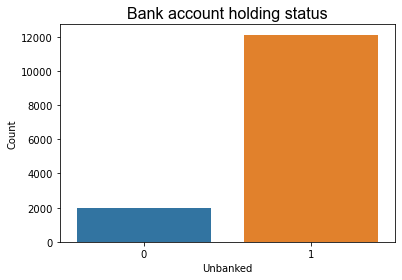

In [149]:
sns.countplot(x='no_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Unbanked')
plt.ylabel('Count')
plt.show;

In [150]:
count_no_acc = len(y_train[y_train['no_acc']==1])
count_acc = len(y_train[y_train['no_acc']==0])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", round(pct_of_no_acc*100,2))
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", round(pct_of_acc*100,2))

percentage of no account: 85.93
percentage of account 14.07


Classes are __very imbalanced__ - investigate threshold, over and undersampling

In [151]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [152]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,df['no_acc']],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df, df['no_acc']],axis=1)

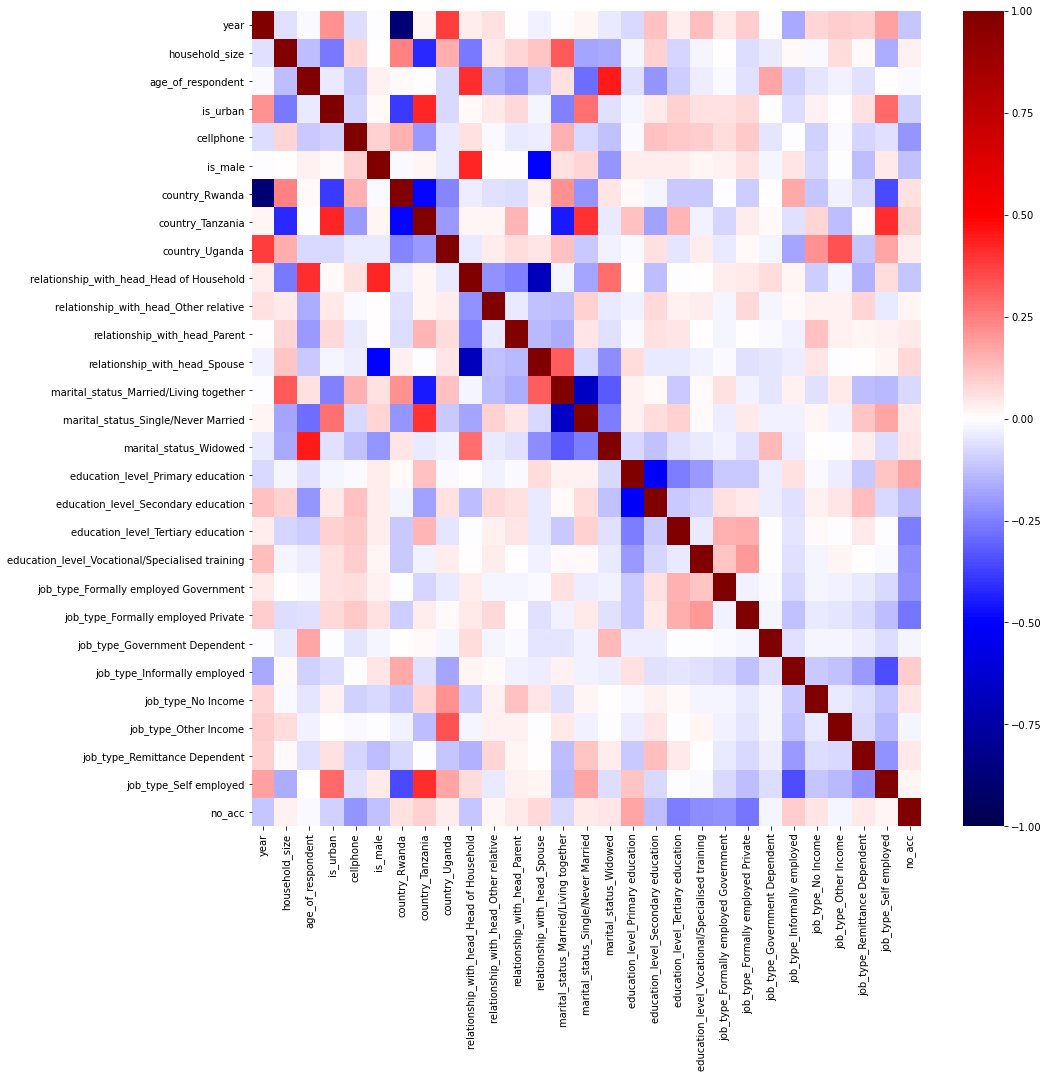

In [153]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

Note that some of these features are correlated and should be removed during analysis below

## Simple logistic regression

Testing with a single variable: is_male

In [154]:
#Model on is_male first
lm_1 = sm.Logit(df_train['no_acc'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['is_male']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 6


In [155]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 no_acc   No. Observations:                14114
Model:                          Logit   Df Residuals:                    14112
Method:                           MLE   Df Model:                            1
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:                 0.01691
Time:                        17:16:07   Log-Likelihood:                -5636.9
converged:                       True   LL-Null:                       -5733.9
Covariance Type:            nonrobust   LLR p-value:                 4.398e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1251      0.035     60.055      0.000       2.056       2.194
is_male       -0.6779      0.049    -13.887      0.000      -0.774      -0.582
==============================================================================
"""

In [156]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['is_male']], df_train['no_acc'])

LogisticRegression(C=100000, solver='newton-cg')

In [157]:
print('intercept: ', round(lm_1.intercept_[0], 3))
print('is_male coef: ', round(lm_1.coef_[0][0], 3))

intercept:  2.125
is_male coef:  -0.678


In [158]:
df_eval = df_val.copy()
df_eval['pred'] = lm_1.predict(df_val[['is_male']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['no_acc']

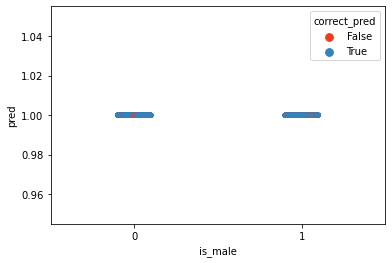

In [159]:
sns.stripplot(data=df_eval,
              x='is_male',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [160]:
lm_1.predict_proba(df_val[['is_male']])[:5]

array([[0.10668258, 0.89331742],
       [0.19044297, 0.80955703],
       [0.10668258, 0.89331742],
       [0.10668258, 0.89331742],
       [0.19044297, 0.80955703]])

In [161]:
confusion_matrix(df_eval['no_acc'], df_eval['pred'])

array([[   0,  492],
       [   0, 3037]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 3037 | 0|
| **is account (1)** | 492 | 0 |

I believe it is predicting all no account because of the following:
* Classes are very imbalanced (85:15 no account to account)
* One variable alone may not be sufficient enough in this instance
* Perhaps because is_male class is also imbalanced?

## Multiple regression - all features
The below analysis is a multiple logistic regression for all features 

In [162]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

The below analysis includes all features. Thereafter the analyses remove insignificant features one by one.

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on val set: 0.89

 Feature coefficient results: 

household_size : -0.002
age_of_respondent : -0.013
is_urban : -0.272
cellphone : -1.633
is_male : -0.455
country_Rwanda : 0.336
country_Tanzania : 1.267
country_Uganda : 1.214
relationship_with_head_Head of Household : -0.800
relationship_with_head_Other relative : -0.123
relationship_with_head_Parent : -0.028
relationship_with_head_Spouse : -0.573
marital_status_Married/Living together : -0.036
marital_status_Single/Never Married : 0.125
marital_status_Widowed : -0.064
education_level_Primary education : -0.761
education_level_Secondary education : -1.764
education_level_Tertiary education : -3.234
education_level_Vocational/Specialised training : -2.774
job_type_Formally employed Government : -1.615
job_type_Formally employed Private : -1.725
job_type_Government Dependent : -1.214
job_type_Informally employed : 0.361
job_type_No Income : 0.187
job_type_Other Income : -0.673
job_type_Remittanc

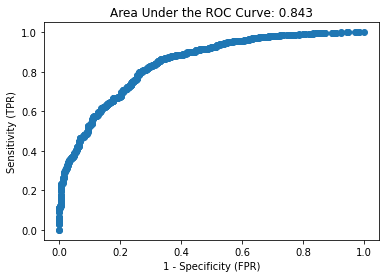

In [175]:
full = LogReg(train_x=x_train[features],train_y = y_train,features=features,val_x=x_val[features],val_y = y_val, dropped=None)

full.fit_pred()

full.get_coefs()

df_val['preds'] = full.get_preds()

full.conf_matrix()

full.roc()

The model should optimise for recall given the importance of identifying the unbanked and understanding the most important features linked to being unbanked. Therefore, the recall for the positive class is quite good. However, precision is comparatively low meaning that banked individuals are being classified as unbanked. 

Precision and recall for negative class are much lower - again because many banked are being classified as unbanked

## Adjusting threshold

In [228]:
threshold = .55
y_pred = np.where((full.get_proba()[:, 0] > threshold),0,1)

print('Confusion matrix')
print(confusion_matrix(y_val, 
                 full.get_preds()))

x_val['preds'] = np.where((full.get_proba()[:, 0] > threshold),0,1)
df_comp = x_val[(y_val != x_val['preds']) & (x_val['household_size'] ==1)]

print('\n','Classification report')
print(classification_report(y_val, x_val['preds']))

Confusion matrix
[[ 168  324]
 [  79 2958]]


<ipython-input-228-d2c04af586f4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['preds'] = np.where((full.get_proba()[:, 0] > threshold),0,1)



 Classification report
              precision    recall  f1-score   support

           0       0.72      0.30      0.43       492
           1       0.90      0.98      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.81      0.64      0.68      3529
weighted avg       0.87      0.89      0.87      3529



As expected, improvement in prediction of the positive class but correct prediction of negative class (the banked population) declines

## Multiple regression removing unused features

### Removing parent and other relative

In [165]:
features2 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on val set: 0.89

 Feature coefficient results: 

age_of_respondent : -0.013
household_size : -0.001
is_urban : -0.274
cellphone : -1.632
is_male : -0.456
country_Rwanda : 0.337
country_Tanzania : 1.264
country_Uganda : 1.208
relationship_with_head_Head of Household : -0.760
relationship_with_head_Spouse : -0.535
marital_status_Married/Living together : -0.035
marital_status_Single/Never Married : 0.132
marital_status_Widowed : -0.061
education_level_Primary education : -0.762
education_level_Secondary education : -1.763
education_level_Tertiary education : -3.233
education_level_Vocational/Specialised training : -2.774
job_type_Formally employed Government : -1.614
job_type_Formally employed Private : -1.730
job_type_Government Dependent : -1.213
job_type_Informally employed : 0.360
job_type_No Income : 0.188
job_type_Remittance Dependent : 0.203
job_type_Other Income : -0.672
job_type_Self employed : -0.462

 Confusion matrix
[[ 169  323]
 [

<ipython-input-173-8a57167fe860>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_x['proba_bank'] = self.lm.predict_proba(self.val_x[self.features])[:, 1]


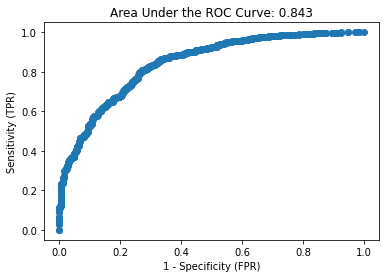

In [176]:
subset2 = LogReg(train_x=x_train[features2],train_y=y_train,features=features2,val_x=x_val[features2],val_y=y_val, dropped=['relationship_with_head_Other relative','relationship_with_head_Parent'])

subset2.fit_pred()

subset2.get_coefs()

df_val['preds'] = subset2.get_preds()

subset2.conf_matrix()

subset2.roc()

Very minor improvement in prediction of both positive and negative classes

### Removing married / living together

In [177]:
features3 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on val set: 0.89

 Feature coefficient results: 

age_of_respondent : -0.013
household_size : -0.002
is_urban : -0.274
cellphone : -1.635
is_male : -0.460
country_Rwanda : 0.337
country_Tanzania : 1.272
country_Uganda : 1.209
relationship_with_head_Head of Household : -0.769
relationship_with_head_Spouse : -0.551
marital_status_Single/Never Married : 0.154
marital_status_Widowed : -0.036
education_level_Primary education : -0.763
education_level_Secondary education : -1.764
education_level_Tertiary education : -3.233
education_level_Vocational/Specialised training : -2.776
job_type_Formally employed Government : -1.614
job_type_Formally employed Private : -1.730
job_type_Government Dependent : -1.212
job_type_Informally employed : 0.360
job_type_No Income : 0.190
job_type_Remittance Dependent : 0.203
job_type_Other Income : -0.672
job_type_Self employed : -0.462

 Confusion matrix
[[ 170  322]
 [  78 2959]] 

Classification report
            

<ipython-input-173-8a57167fe860>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_x['proba_bank'] = self.lm.predict_proba(self.val_x[self.features])[:, 1]


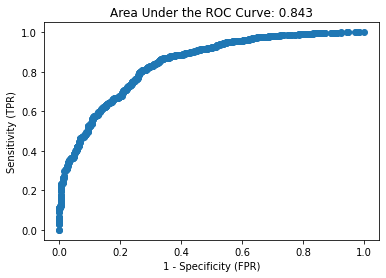

In [178]:
subset3 = LogReg(train_x=x_train[features3],train_y=y_train,features=features3,val_x=x_val[features3],val_y=y_val, dropped=['relationship_with_head_Other relative','relationship_with_head_Parent','marital_status_Married/Living together'])

subset3.fit_pred()

subset3.get_coefs()

df_val['preds'] = subset3.get_preds()

subset3.conf_matrix()

subset3.roc()

No change in prediction

### Removing household size

In [179]:
features4 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-173-8a57167fe860>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_x['proba_bank'] = self.lm.predict_proba(self.val_x[self.features])[:, 1]


Accuracy of logistic regression classifier on val set: 0.89

 Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.273
cellphone : -1.637
is_male : -0.461
country_Rwanda : 0.335
country_Tanzania : 1.275
country_Uganda : 1.207
relationship_with_head_Head of Household : -0.766
relationship_with_head_Spouse : -0.550
marital_status_Single/Never Married : 0.155
marital_status_Widowed : -0.035
education_level_Primary education : -0.765
education_level_Secondary education : -1.766
education_level_Tertiary education : -3.234
education_level_Vocational/Specialised training : -2.776
job_type_Formally employed Government : -1.614
job_type_Formally employed Private : -1.730
job_type_Government Dependent : -1.212
job_type_Informally employed : 0.360
job_type_No Income : 0.189
job_type_Remittance Dependent : 0.202
job_type_Other Income : -0.672
job_type_Self employed : -0.463

 Confusion matrix
[[ 169  323]
 [  78 2959]] 

Classification report
              precision    recall  f

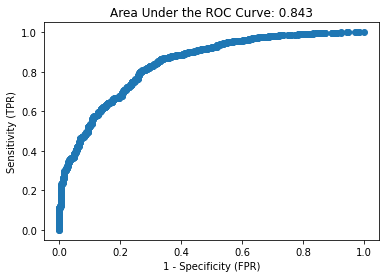

In [180]:
subset4 = LogReg(train_x=x_train[features4],train_y=y_train,features=features4,val_x=x_val[features4],val_y=y_val, 
                 dropped=['relationship_with_head_Other relative','relationship_with_head_Parent','marital_status_Married/Living together','household_size'])

subset4.fit_pred()

subset4.get_coefs()

df_val['preds'] = subset4.get_preds()

subset4.conf_matrix()

subset4.roc()

### Oversampling with model 4 features

In [182]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(x_train[features4], y_train)

In [191]:
from collections import Counter
Counter(y_resampled)

lm_os = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lm_os.fit(X_resampled[features4], y_resampled)

preds_os = lm_os.predict(x_val[features4])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_os.score(
    x_val[features4], y_val)))

print('\n','Feature coefficient results: \n')
for feature, coef in zip(X_resampled.columns, lm_os.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')
        
        
print('\n','Confusion matrix')
print(confusion_matrix(y_val, 
                 preds_os))

print('\n','Classification report')
print(classification_report(y_val, preds_os))

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on val set: 0.791

 Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.226
cellphone : -1.697
is_male : -0.495
country_Rwanda : 0.423
country_Tanzania : 1.405
country_Uganda : 1.406
relationship_with_head_Head of Household : -0.661
relationship_with_head_Spouse : -0.434
marital_status_Single/Never Married : 0.184
marital_status_Widowed : -0.106
education_level_Primary education : -0.801
education_level_Secondary education : -1.794
education_level_Tertiary education : -3.254
education_level_Vocational/Specialised training : -2.885
job_type_Formally employed Government : -1.727
job_type_Formally employed Private : -1.778
job_type_Government Dependent : -1.439
job_type_Informally employed : 0.334
job_type_No Income : 0.138
job_type_Remittance Dependent : 0.185
job_type_Other Income : -0.682
job_type_Self employed : -0.547

 Confusion matrix
[[ 354  138]
 [ 601 2436]]

 Classification report
              precision    recall  

As expected, improved prediction of the minority class but worse prediction of the majority (positive) class. 

### Removing widowed

In [192]:
features5 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-173-8a57167fe860>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_x['proba_bank'] = self.lm.predict_proba(self.val_x[self.features])[:, 1]


Accuracy of logistic regression classifier on val set: 0.89

 Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.273
cellphone : -1.611
is_male : -0.450
country_Rwanda : 0.341
country_Tanzania : 1.275
country_Uganda : 1.212
relationship_with_head_Head of Household : -0.757
relationship_with_head_Spouse : -0.529
marital_status_Single/Never Married : 0.165
education_level_Primary education : -0.746
education_level_Secondary education : -1.744
education_level_Tertiary education : -3.213
education_level_Vocational/Specialised training : -2.754
job_type_Formally employed Government : -1.608
job_type_Formally employed Private : -1.722
job_type_Government Dependent : -1.211
job_type_Informally employed : 0.368
job_type_No Income : 0.197
job_type_Remittance Dependent : 0.212
job_type_Other Income : -0.666
job_type_Self employed : -0.456

 Confusion matrix
[[ 169  323]
 [  79 2958]] 

Classification report
              precision    recall  f1-score   support

           0 

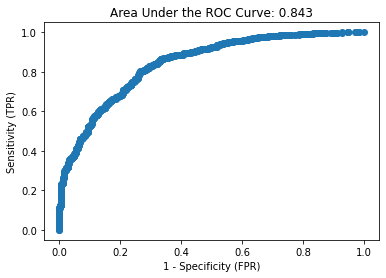

In [193]:
subset5 = LogReg(train_x=x_train[features5],train_y=y_train,features=features5,val_x=x_val[features5],val_y=y_val, 
                 dropped=['relationship_with_head_Other relative','relationship_with_head_Parent',
                          'marital_status_Married/Living together','household_size',
                         'marital_status_Widowed'])

subset5.fit_pred()

subset5.get_coefs()

df_val['preds'] = subset5.get_preds()

subset5.conf_matrix()

subset5.roc()

### Removing Rwanda

In [194]:
features6 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-173-8a57167fe860>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_x['proba_bank'] = self.lm.predict_proba(self.val_x[self.features])[:, 1]


Accuracy of logistic regression classifier on val set: 0.89

 Feature coefficient results: 

age_of_respondent : -0.015
is_urban : -0.314
cellphone : -1.620
is_male : -0.441
country_Tanzania : 1.210
country_Uganda : 1.049
relationship_with_head_Head of Household : -0.858
relationship_with_head_Spouse : -0.625
education_level_Primary education : -0.787
education_level_Secondary education : -1.827
education_level_Tertiary education : -3.294
education_level_Vocational/Specialised training : -2.877
job_type_Formally employed Government : -1.655
job_type_Formally employed Private : -1.789
job_type_Government Dependent : -1.203
job_type_Informally employed : 0.335
job_type_No Income : 0.164
job_type_Remittance Dependent : 0.147
job_type_Other Income : -0.652
job_type_Self employed : -0.517

 Confusion matrix
[[ 172  320]
 [  79 2958]] 

Classification report
              precision    recall  f1-score   support

           0       0.69      0.35      0.46       492
           1       0.90   

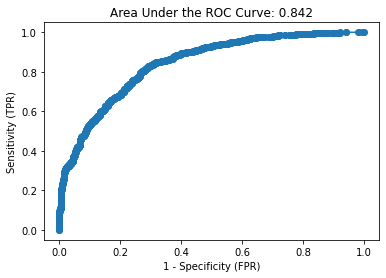

In [195]:
subset6 = LogReg(train_x=x_train[features6],train_y=y_train,features=features6,val_x=x_val[features6],val_y=y_val, 
                 dropped=['relationship_with_head_Other relative','relationship_with_head_Parent',
                          'marital_status_Married/Living together','household_size',
                         'marital_status_Widowed','country_Rwanda'])

subset6.fit_pred()

subset6.get_coefs()

df_val['preds'] = subset6.get_preds()

subset6.conf_matrix()

subset6.roc()

### Removing Single

In [196]:
features7 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-173-8a57167fe860>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_x['proba_bank'] = self.lm.predict_proba(self.val_x[self.features])[:, 1]


Accuracy of logistic regression classifier on val set: 0.89

 Feature coefficient results: 

age_of_respondent : -0.014
is_urban : -0.257
cellphone : -1.631
is_male : -0.448
country_Rwanda : 0.336
country_Tanzania : 1.337
country_Uganda : 1.201
relationship_with_head_Head of Household : -0.823
relationship_with_head_Spouse : -0.611
education_level_Primary education : -0.754
education_level_Secondary education : -1.751
education_level_Tertiary education : -3.220
education_level_Vocational/Specialised training : -2.762
job_type_Formally employed Government : -1.608
job_type_Formally employed Private : -1.718
job_type_Government Dependent : -1.188
job_type_Informally employed : 0.365
job_type_No Income : 0.183
job_type_Remittance Dependent : 0.222
job_type_Other Income : -0.657
job_type_Self employed : -0.455

 Confusion matrix
[[ 170  322]
 [  78 2959]] 

Classification report
              precision    recall  f1-score   support

           0       0.69      0.35      0.46       492
   

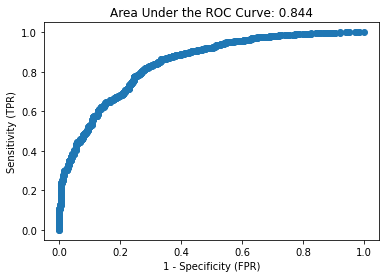

In [197]:
subset7 = LogReg(train_x=x_train[features7],train_y=y_train,features=features7,val_x=x_val[features7],val_y=y_val, 
                 dropped=['relationship_with_head_Other relative','relationship_with_head_Parent',
                          'marital_status_Married/Living together','household_size',
                         'marital_status_Widowed','marital_status_Single/Never Married'])

subset7.fit_pred()

subset7.get_coefs()

df_val['preds'] = subset7.get_preds()

subset7.conf_matrix()

subset7.roc()

### Removing Other income

In [205]:
features8 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Tanzania','country_Rwanda', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Self employed']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-173-8a57167fe860>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_x['proba_bank'] = self.lm.predict_proba(self.val_x[self.features])[:, 1]


Accuracy of logistic regression classifier on val set: 0.89

 Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.313
cellphone : -1.630
is_male : -0.443
country_Tanzania : 1.309
country_Rwanda : 0.330
country_Uganda : 1.024
relationship_with_head_Head of Household : -0.815
relationship_with_head_Spouse : -0.592
education_level_Primary education : -0.761
education_level_Secondary education : -1.768
education_level_Tertiary education : -3.249
education_level_Vocational/Specialised training : -2.784
job_type_Formally employed Government : -1.481
job_type_Formally employed Private : -1.565
job_type_Government Dependent : -1.080
job_type_Informally employed : 0.481
job_type_No Income : 0.388
job_type_Remittance Dependent : 0.352
job_type_Self employed : -0.298

 Confusion matrix
[[ 170  322]
 [  79 2958]] 

Classification report
              precision    recall  f1-score   support

           0       0.68      0.35      0.46       492
           1       0.90      0.97 

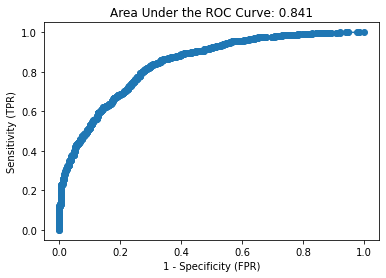

In [206]:
subset8 = LogReg(train_x=x_train[features8],train_y=y_train,features=features8,val_x=x_val[features8],val_y=y_val, 
                 dropped=['relationship_with_head_Other relative','relationship_with_head_Parent',
                          'marital_status_Married/Living together','household_size',
                         'marital_status_Widowed','marital_status_Single/Never Married',
                         'job_type_Other Income'])

subset8.fit_pred()

subset8.get_coefs()

df_val['preds'] = subset8.get_preds()

subset8.conf_matrix()

subset8.roc()

### Removing Age of respondent

In [207]:
features9 = ['is_urban', 'cellphone',
       'is_male', 'country_Tanzania','country_Rwanda', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Self employed']

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-173-8a57167fe860>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_x['proba_bank'] = self.lm.predict_proba(self.val_x[self.features])[:, 1]


Accuracy of logistic regression classifier on val set: 0.88

 Feature coefficient results: 

is_urban : -0.301
cellphone : -1.590
is_male : -0.438
country_Tanzania : 1.322
country_Rwanda : 0.364
country_Uganda : 1.096
relationship_with_head_Head of Household : -1.035
relationship_with_head_Spouse : -0.727
education_level_Primary education : -0.657
education_level_Secondary education : -1.624
education_level_Tertiary education : -3.081
education_level_Vocational/Specialised training : -2.656
job_type_Formally employed Government : -1.426
job_type_Formally employed Private : -1.481
job_type_Government Dependent : -1.317
job_type_Informally employed : 0.568
job_type_No Income : 0.431
job_type_Remittance Dependent : 0.409
job_type_Self employed : -0.236

 Confusion matrix
[[ 160  332]
 [  84 2953]] 

Classification report
              precision    recall  f1-score   support

           0       0.66      0.33      0.43       492
           1       0.90      0.97      0.93      3037

    ac

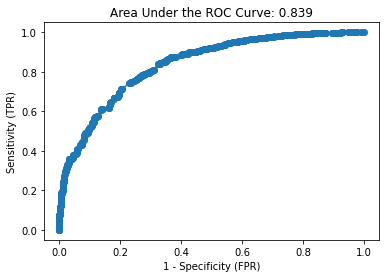

In [208]:
subset9 = LogReg(train_x=x_train[features9],train_y=y_train,features=features9,val_x=x_val[features9],val_y=y_val, 
                 dropped=['relationship_with_head_Other relative','relationship_with_head_Parent',
                          'marital_status_Married/Living together','household_size',
                         'marital_status_Widowed','marital_status_Single/Never Married',
                         'job_type_Other Income','age_of_respondent'])

subset9.fit_pred()

subset9.get_coefs()

df_val['preds'] = subset9.get_preds()

subset9.conf_matrix()

subset9.roc()

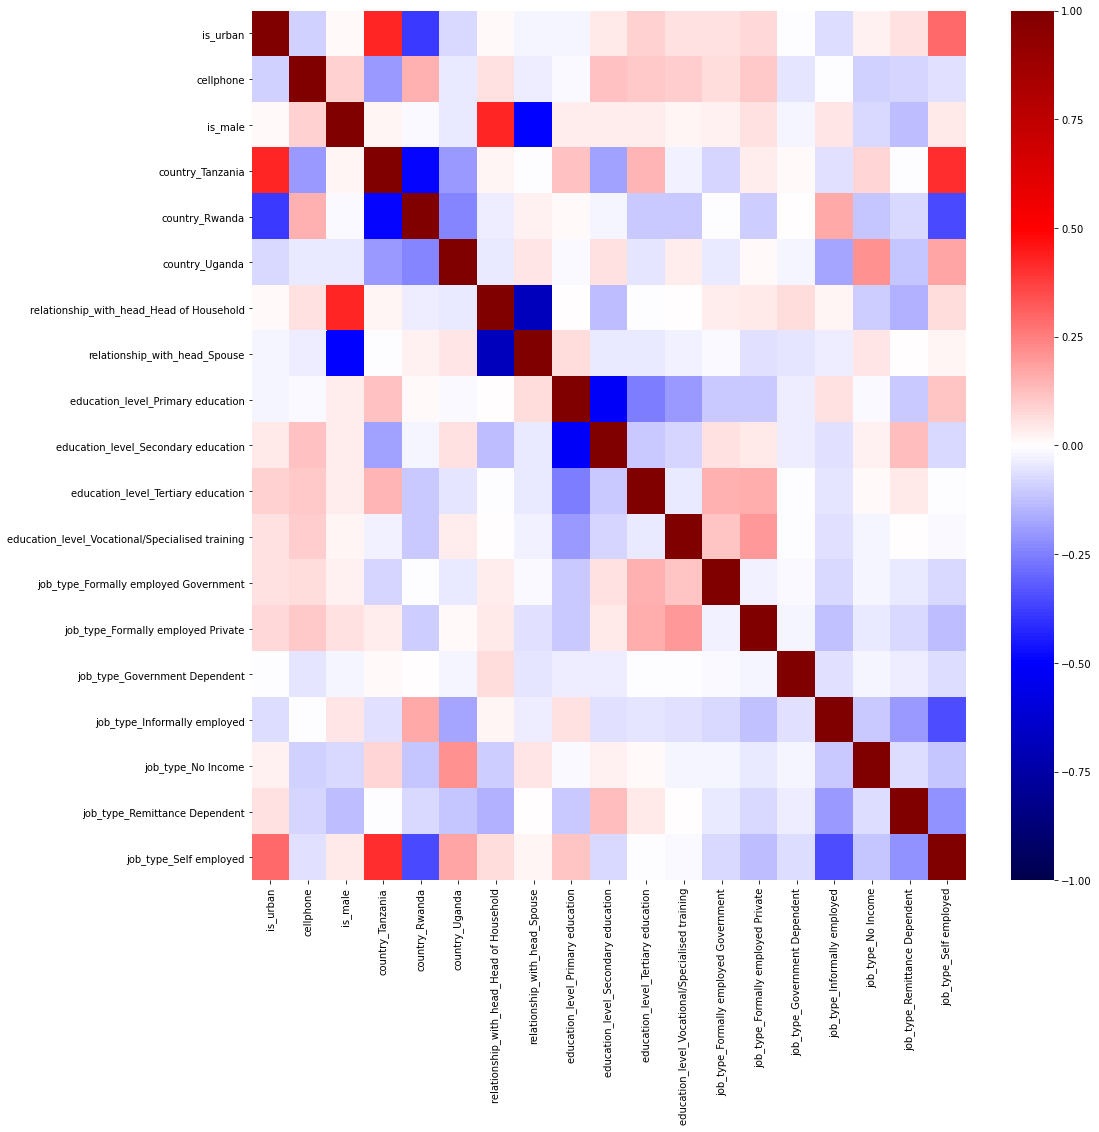

In [209]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(subset9.train_x.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

# Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

## 1. Preparing the test sample 

In [220]:
df_test = pd.read_csv('/Users/tawneykirkland/GitStuff/03-mcnulty/04-data/data_test_clean.csv')

In [221]:
x_test_cont = df_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = df_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

y_test = df_test[['no_acc']]

In [222]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=df_test.index)

In [223]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [224]:
df_test = pd.concat([combo_test_df,y_test],axis=1)

## 2. Testing the model on the test sample

### Model 1 - all features

In [226]:
preds1_test = full.fit_pred(df_test[features]) ## Need to rewrite to accept test dataframe

TypeError: fit_pred() takes 1 positional argument but 2 were given

In [124]:
confusion_matrix(df_test['no_acc'], 
                 preds1_test)

array([[ 291,  543],
       [ 149, 4898]])


| | predict banked (0) | predict unbanked (1)|
|---|---|---|
| **is banked (0)** | 290 | 544|
| **is UNbanked (1)** | 149 | 4898 |

In [125]:
print(classification_report(df_test['no_acc'], preds1_test))

              precision    recall  f1-score   support

           0       0.66      0.35      0.46       834
           1       0.90      0.97      0.93      5047

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.70      5881
weighted avg       0.87      0.88      0.87      5881



Consistent performance across validation and test

#### Multiple regression with model 13

In [126]:
df_test_17 = df_test.copy()

In [127]:
preds17_test = lm_17.predict(df_test_17[features17])
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(
    lm_17.score(df_test_17[features17],df_test_17['no_acc'])))

Accuracy of logistic regression classifier on test set: 0.881


In [128]:
confusion_matrix(df_test_17['no_acc'], 
                 preds17_test)

array([[ 284,  550],
       [ 148, 4899]])

In [129]:
print(classification_report(df_test_17['no_acc'], preds17_test))

              precision    recall  f1-score   support

           0       0.66      0.34      0.45       834
           1       0.90      0.97      0.93      5047

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.69      5881
weighted avg       0.86      0.88      0.86      5881



Model is broadly consistent across train - val - test

In [130]:
df_test_17['proba_bank'] = lm_17.predict_proba(df_test_17[features17])[:, 1]

fpr17_test, tpr17_test, thresholds17_test = roc_curve(df_test_17['no_acc'],
                                 df_test_17['proba_bank'])

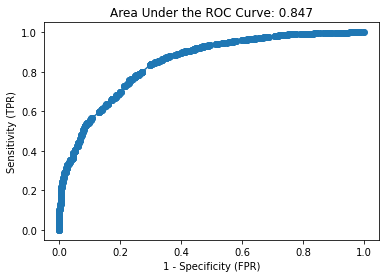

In [131]:
plot_roc(df_test_17['no_acc'], df_test_17['proba_bank'],fpr17_test,tpr17_test)

With model 13 the AUC is 0.853

In [132]:
df_test_17['preds'] = lm_17.predict(df_test_17[features17])

In [133]:
final_test = pd.concat([df_test_17,x_test_cat],axis=1)

In [134]:
# Send to csv for visualisation in Tableau
#final_test.to_csv('test_preds.csv')